<a href="https://colab.research.google.com/github/pchatfield/coin-analyzer/blob/main/HT_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heads or tails classifier

- Create a classifier to determine whether a coin image is heads or tails

In [9]:
# imports

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator, img_to_array, image
from keras.utils import np_utils
import json
from PIL import Image
import numpy as np

In [2]:
# import data from drive

from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/My Drive/Data Science Projects/HT_dataset"

Mounted at /content/drive


In [3]:
data_dir = "/content/drive/My Drive/Data Science Projects/HT_dataset"

In [5]:
image_size = (180, 180)
batch_size = 4

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size)

Found 54 files belonging to 2 classes.
Using 44 files for training.
Found 54 files belonging to 2 classes.
Using 10 files for validation.


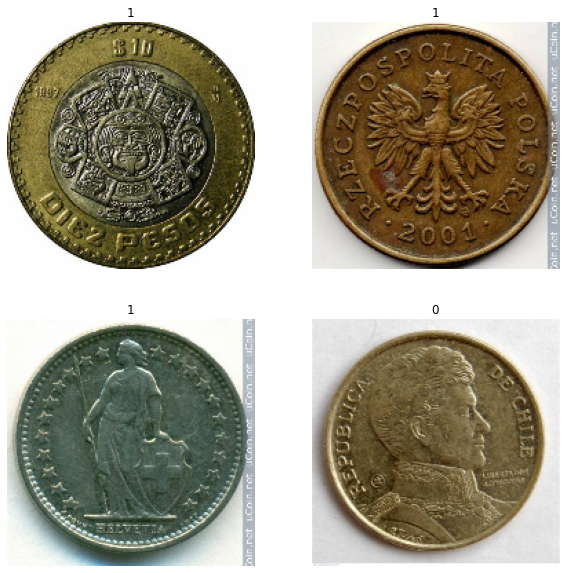

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [10]:
# data augmentation

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

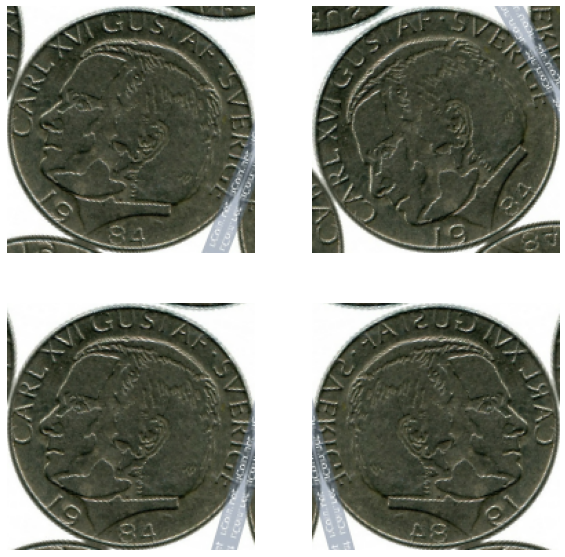

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(4):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [12]:
# buffered prefetching

train_ds = train_ds.prefetch(buffer_size=4)
val_ds = val_ds.prefetch(buffer_size=4)


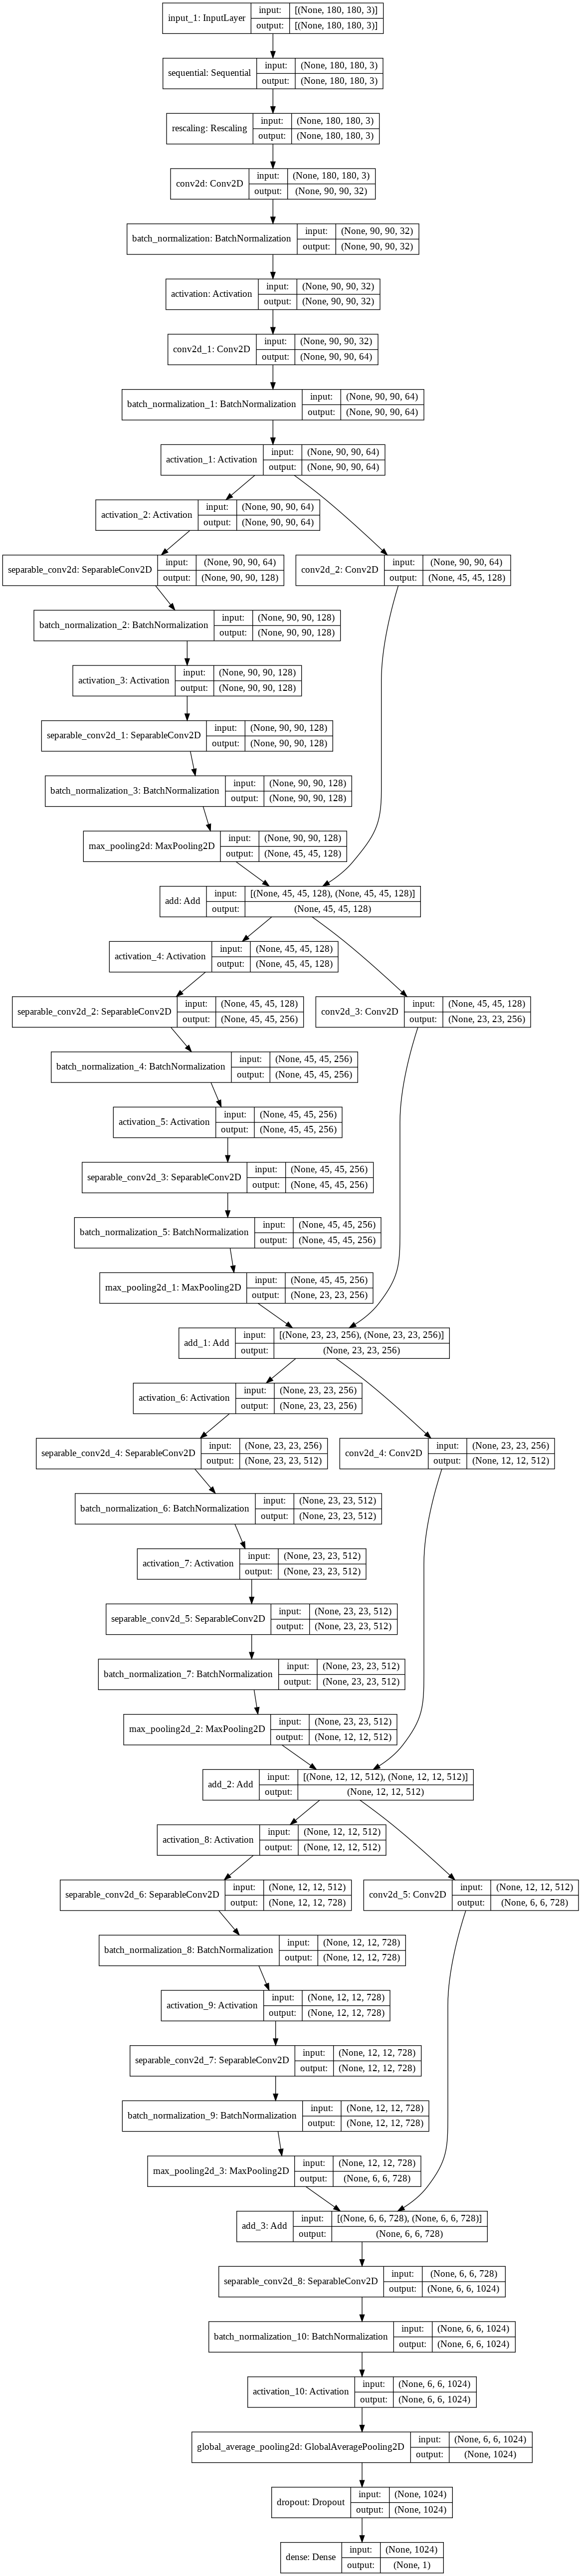

In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [14]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
11/11 [==============================] - 17s 1s/step - loss: 1.4241 - accuracy: 0.3182 - val_loss: 0.6934 - val_accuracy: 0.5000


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
11/11 [==============================] - 11s 1s/step - loss: 0.6885 - accuracy: 0.5455 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 3/50
11/11 [==============================] - 11s 1s/step - loss: 0.7695 - accuracy: 0.5909 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 4/50
11/11 [==============================] - 11s 1s/step - loss: 0.6127 - accuracy: 0.6364 - val_loss: 0.6955 - val_accuracy: 0.5000
Epoch 5/50
11/11 [==============================] - 11s 1s/step - loss: 0.5195 - accuracy: 0.7500 - val_loss: 0.6999 - val_accuracy: 0.5000
Epoch 6/50
11/11 [==============================] - 11s 1s/step - loss: 0.6422 - accuracy: 0.7045 - val_loss: 0.7083 - val_accuracy: 0.5000
Epoch 7/50
11/11 [==============================] - 11s 1s/step - loss: 0.6983 - accuracy: 0.6591 - val_loss: 0.7075 - val_accuracy: 0.5000
Epoch 8/50
11/11 [==============================] - 11s 1s/step - loss: 0.7123 - accuracy: 0.6364 - val_loss: 0.7299 - val_accuracy: 0.5000
Epoch 9/50
11/11 [==

In [17]:
img = keras.preprocessing.image.load_img(
    "/content/drive/My Drive/Data Science Projects/035__50 Cents_new_zealand.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent heads and %.2f percent tails."
    % (100 * (1 - score), 100 * score)
)


This image is 91.10 percent heads and 8.90 percent tails.
